In [1]:
import PostProcessing as PP
import numpy as np
from CollisionApprox import Collision_approx as ca
from nu_e_coll import nu_e_collisions as ve
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import support_functions as sf

mass = 300
mix = 7e-05

In [ ]:
PP.pp(300,1.28e-5)

In [ ]:
PP.pp(300,7e-5)

In [ ]:
PP.inspect_graphs(300,1.28e-5)

In [ ]:
PP.inspect_graphs(300,7e-5)

In [ ]:
PP.make_graphs(300,1.28e-5)

In [ ]:
PP.make_graphs(300,7e-5)

In [ ]:
PP.make_movies(300,1.28e-5)

In [ ]:
PP.make_movies(300,7e-5)

In [ ]:
dilresults = np.load("/Users/hannahrasmussen/Work/Most_recent_code/300data/300data/300data_final.npz")
lifetime_array = dilresults['lifetime']
dil_array = dilresults['Dilution_Factor']
N_eff_array = dilresults['N_eff']

plt.figure(figsize=(8,6))
plt.semilogx(lifetime_array,dil_array,'o',color='k')
plt.xlabel("$\\tau(s)$",fontsize=16)
plt.ylabel("Dilution Factor",fontsize=16)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
#plt.savefig("dilution.pdf")

plt.figure(figsize=(8,6))
plt.semilogx(lifetime_array,N_eff_array,'o',color='k')
plt.xlabel("$\\tau(s)$",fontsize=16)
plt.ylabel("$N_{\\rm eff}$",fontsize=16)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
#plt.savefig("neff.pdf")

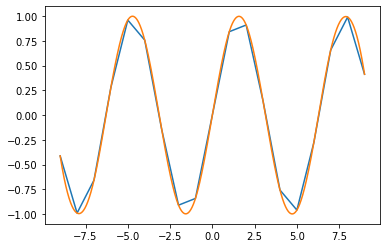

In [2]:
pracx = np.array([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
pracy = np.sin(pracx)

cs_comparison = sp.interpolate.CubicSpline(pracx,pracy)

xfull = np.linspace(-9,9,10000)
yfull = cs_comparison(xfull)

plt.figure()
plt.plot(pracx,pracy)
plt.plot(xfull,yfull)
plt.show()

In [3]:
def cs(x,y):
    n = len(x)-1 #THE NUMBER OF INTERVALS
    h = x[1:]-x[:-1] #interval widths, not necessarily constant, has length n (one less than x and y)
    a = np.zeros(n)
    b = np.zeros(n)
    c = np.zeros(n)
    d = np.zeros(n) 
    sig = np.zeros(n+1) #the right side of the augmented matrix
    tri = np.zeros((n-1,n)) #triagonal matrix to be solved? not sure why it's n-1 by n
    output = np.zeros((n,5))
    
    for i in range(n-1):
        tri[i][i] = 2*(h[i] + h[i+1])
    for i in range(n-2):
        tri[i][i+1] = h[i+1]
        tri[i+1][i] = h[i+1]
    for i in range(1,n):
        tri[i-1][n-1] = 6*(y[i+1]-y[i])/h[i] - 6*(y[i]-y[i-1])/h[i-1]
    
    for i in range(n-2):
        for j in range(i+1,n-1):
            term = tri[j][i]/tri[i][i]
            for k in range(n):
                tri[j][k] = tri[j][k] - term*tri[i][k]          
    
    for i in range(n-1):
        ii = n-2 - i
        sig[ii+1] = tri[ii][n-1]
        for j in range(ii+1,n-1):
            sig[ii+1] = sig[ii+1] - tri[ii][j]*sig[j+1]
        sig[ii+1] = sig[ii+1]/tri[ii][ii]
    
    for i in range(n): #again, the format is ai(x-xi)^3 + bi(x-xi)^2 + ci(x-xi) +di
        a[i] = (sig[i+1]-sig[i])/(6*h[i]);
        b[i] = sig[i]/2
        c[i] = (y[i+1]-y[i])/h[i] - h[i]*(2*sig[i]+sig[i+1])/6;
        d[i] = y[i]
    
    return x[:-1], a, b, c, d

In [4]:
def findy(xarr,yarr,x_val):
    
    x, a, b, c, d = cs(xarr,yarr)
    index = 0
    
    for i in range(len(x)): #want to find the index we'll be using to find y
        if (x_val>x[i]): #if x is going down, not up, as i increases, this will need to be changed to if (x<output[i,0]):
            index = i
            #print(index)
    
    y = a[index]*(x_val-x[index])**3 + b[index]*(x_val-x[index])**2 + c[index]*(x_val-x[index]) + d[index]
    return y

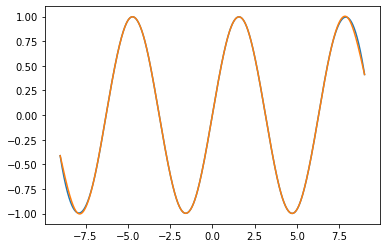

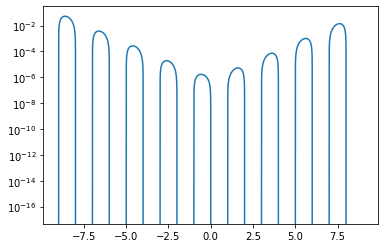

In [5]:
ytry = np.zeros(len(xfull))
for i in range(len(xfull)):
    ytry[i] = findy(pracx,pracy,xfull[i])

plt.figure()
plt.plot(xfull,yfull)
plt.plot(xfull,ytry)
plt.show()

plt.figure()
#plt.plot(xfull,yfull)
plt.semilogy(xfull,ytry-yfull)
plt.show()

In [6]:
results = np.load("/Users/hannahrasmussen/Work/Most_recent_code/{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/movie_arrays.npz".format(mass,mix,mass,mix), allow_pickle=True)
a_arr = results['a']
T_arr = results['T']
t_arr = results['t']
e_mat = results['e']
f_mat = results['f']

rho_nu = np.zeros((len(a_arr),2))
for i in range(len(a_arr)):
    rho_nu[i,0] = 1/a_arr[i] 
    rho_nu[i,1] = (1/(2*np.pi**2*a_arr[i]**4))*sf.trapezoid(f_mat[i]*e_mat[i]**3,e_mat[i])

Tcm_arr, a_arr, b_arr, c_arr, d_arr = cs(rho_nu[:,0],rho_nu[:,1])
Tcm_save = pd.DataFrame(Tcm_arr)
a_save = pd.DataFrame(a_arr)
b_save = pd.DataFrame(b_arr)
c_save = pd.DataFrame(c_arr)
d_save = pd.DataFrame(d_arr)
Tcm_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_Tcm.csv".format(mass,mix,mass,mix,mass,mix))
a_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_a.csv".format(mass,mix,mass,mix,mass,mix))
b_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_b.csv".format(mass,mix,mass,mix,mass,mix))
c_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_c.csv".format(mass,mix,mass,mix,mass,mix))
d_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_d.csv".format(mass,mix,mass,mix,mass,mix))

In [7]:
Tcm_prac = np.logspace(1.1,-3.1,100)
rho_nu_prac = np.zeros(len(Tcm_prac))
for i in range(len(Tcm_prac)):
    index = 0
    x = Tcm_prac[i]
    
    for j in range(len(Tcm_arr)): #want to find the index we'll be using to find y
        if (x<Tcm_arr[j]): #if x is going down, not up, as i increases, this will need to be changed to if (x<output[i,0]):
            index = j

    rho_nu_prac[i] = a_arr[index]*(x-Tcm_arr[index])**3 + b_arr[index]*(x-Tcm_arr[index])**2 + c_arr[index]*(x-Tcm_arr[index]) + d_arr[index]

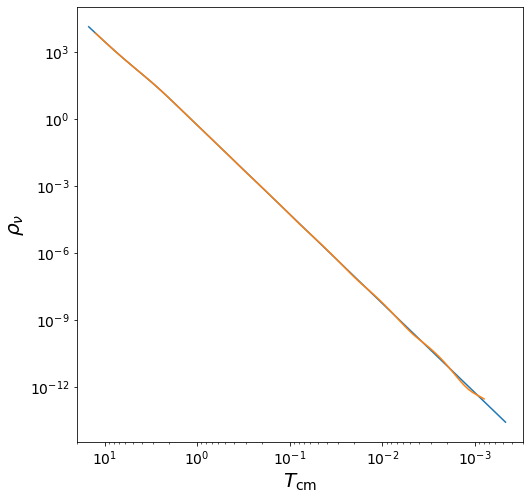

In [8]:
plt.figure(figsize=(8,8))
plt.loglog(rho_nu[:,0],rho_nu[:,1])
plt.loglog(Tcm_prac,rho_nu_prac)
plt.xlim(20,0.0003)
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.xlabel("$T_{\\rm cm}$", fontsize=20)
plt.ylabel("$\\rho_{\\nu}$", fontsize=20)
plt.show()